# **Seminar 9: Heston Model (Part 2)**
---

In [1]:
from dataclasses import dataclass, replace
from copy import deepcopy
from typing import Callable, Union
import math

import numpy as np
import numpy.typing as npt
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

In [2]:
DARK_THEME = True

if DARK_THEME:
    plt.style.use("dark_background")
    mpl.rcParams["figure.facecolor"] = "none"
    mpl.rcParams["axes.facecolor"] = "none"

### Heston model (reminder)

$$dS_t = (r - q)S_t dt + \sqrt{V_t} S_t  dW^{1}_t, \qquad S_0 = s > 0,$$

$$dV_t = \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW^{2}_t, \qquad V_0 = v > 0,$$

$$dW_t^1 dW_t^2 = \rho dt.$$

# Simulation schemes

In [3]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class HestonParams:
    v: float # initial variance V_0
    kappa: float # speed of mean-reversion 
    theta: float # long-term mean
    sigma: float # vol of vol
    rho: float # correlation between brownian motions
    
class BaseHestonSimulState:
    def __init__(
        self,
        params: HestonParams,
        ms: MarketState,
        shape: Union[int, tuple[int]],
    ):
        raise NotImplemented

    @property
    def stock_price(self) -> Floats:
        raise NotImplemented
        
    def advance(
        self,
        dt: float,
        random: np.random.Generator,
    ):
        raise NotImplemented

In [4]:
def simulate_heston(
    params: HestonParams,
    initial_simul_state: BaseHestonSimulState,
    time_stop: float = 1.0,
    n_time_steps: int = 100,
    random_seed: int = 0x11A_3AB0D,
    ret_intermediate_states: bool = False,
):
    random = np.random.default_rng(random_seed)
    dt = (time_stop - ms.time) / n_time_steps
    hs = initial_simul_state
    
    if ret_intermediate_states:
        states = [deepcopy(hs)]
        
    stock_price = np.empty((*np.shape(initial_simul_state.stock_price), n_time_steps + 1))
    stock_price[:, 0] = initial_simul_state.stock_price
    
    for i in trange(n_time_steps):
        hs.advance(dt, random)
        stock_price[:, i + 1] = hs.stock_price
        
        if ret_intermediate_states:
            states.append(deepcopy(hs))
    
    if ret_intermediate_states:
        return stock_price, states
    
    return stock_price

In [5]:
N_PATHS = 10
N_STEPS = 100
T = 1.0

params = HestonParams(v=0.1, kappa=2, theta=0.1, sigma=0.7, rho=-0.2)
ms = MarketState(stock_price=100.0, interest_rate=0.0, time=0)

### Euler(-Maruyama) schemes

$$
dy\rightarrow \Delta y
$$
$$
dW_t \rightarrow z \sim \mathcal{N}\left(z \mid 0, \Delta t \right)
$$

Then Monte-Carlo go *brrrrrr*

## 1. Naive

The Naive Euler scheme for the Heston model is:

\begin{align*}
&\hat S_{t_{t+i}} = \hat S_{t_i} + r \hat S_{t_i} \Delta t 
  + \sqrt{\hat v_{t_i}}\hat S_{t_i} 
    (\rho \Delta W_{t_{i+1}}^1 + \sqrt{1-\rho^2} \Delta W_{t_{i+1}}^2),\\
&\hat v_{t_{t+i}} = \hat v_{t_i} + \kappa(\theta - \hat v_{t_i}) \Delta t 
  + \sigma \sqrt{\hat v_{t_i}} \Delta W_{t_{i+1}}^1
\end{align*}

What can go wrong?

In [6]:
@dataclass
class NaiveEulerSimulState(BaseHestonSimulState):
    def __init__(
        self,
        params: HestonParams,
        ms: MarketState,
        shape: Union[int, tuple[int]],
    ):
        self._stock_price = np.full(shape, ms.stock_price)
        self._variance = np.full(shape, params.v)
        self._interest_rate = ms.interest_rate
        self._p = params
    
    @property
    def stock_price(self):
        return self._stock_price
    
    @property
    def variance(self):
        return self._variance

    def advance(
        self,
        dt: float,
        random: np.random.Generator,
    ):
        z1, z2 = random.normal(size=(2, *np.shape(self._stock_price)))
        dW_v = z1 * math.sqrt(dt)
        dW_s = math.sqrt(dt) * (self._p.rho * z1 + math.sqrt(1 - self._p.rho**2) * z2)
        new_v = (
            self._variance
            + self._p.kappa * (self._p.theta - self._variance) * dt
            + self._p.sigma * np.sqrt(self._variance) * dW_v
        )
        new_s = (
            self._stock_price
            + self._interest_rate * self._stock_price * dt
            + np.sqrt(self._variance) * self._stock_price * dW_s
        )
        self._stock_price = new_s
        self._variance = new_v

In [7]:
hs = NaiveEulerSimulState(params, ms, N_PATHS)
paths, states = simulate_heston(
    params,
    # replace(params, theta=20.0),
    hs,
    time_stop=T,
    n_time_steps=N_STEPS,
    ret_intermediate_states=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_501824/368106128.py:33: RuntimeWarning: invalid value encountered in sqrt
  + self._p.sigma * np.sqrt(self._variance) * dW_v
/tmp/ipykernel_501824/368106128.py:38: RuntimeWarning: invalid value encountered in sqrt
  + np.sqrt(self._variance) * self._stock_price * dW_s


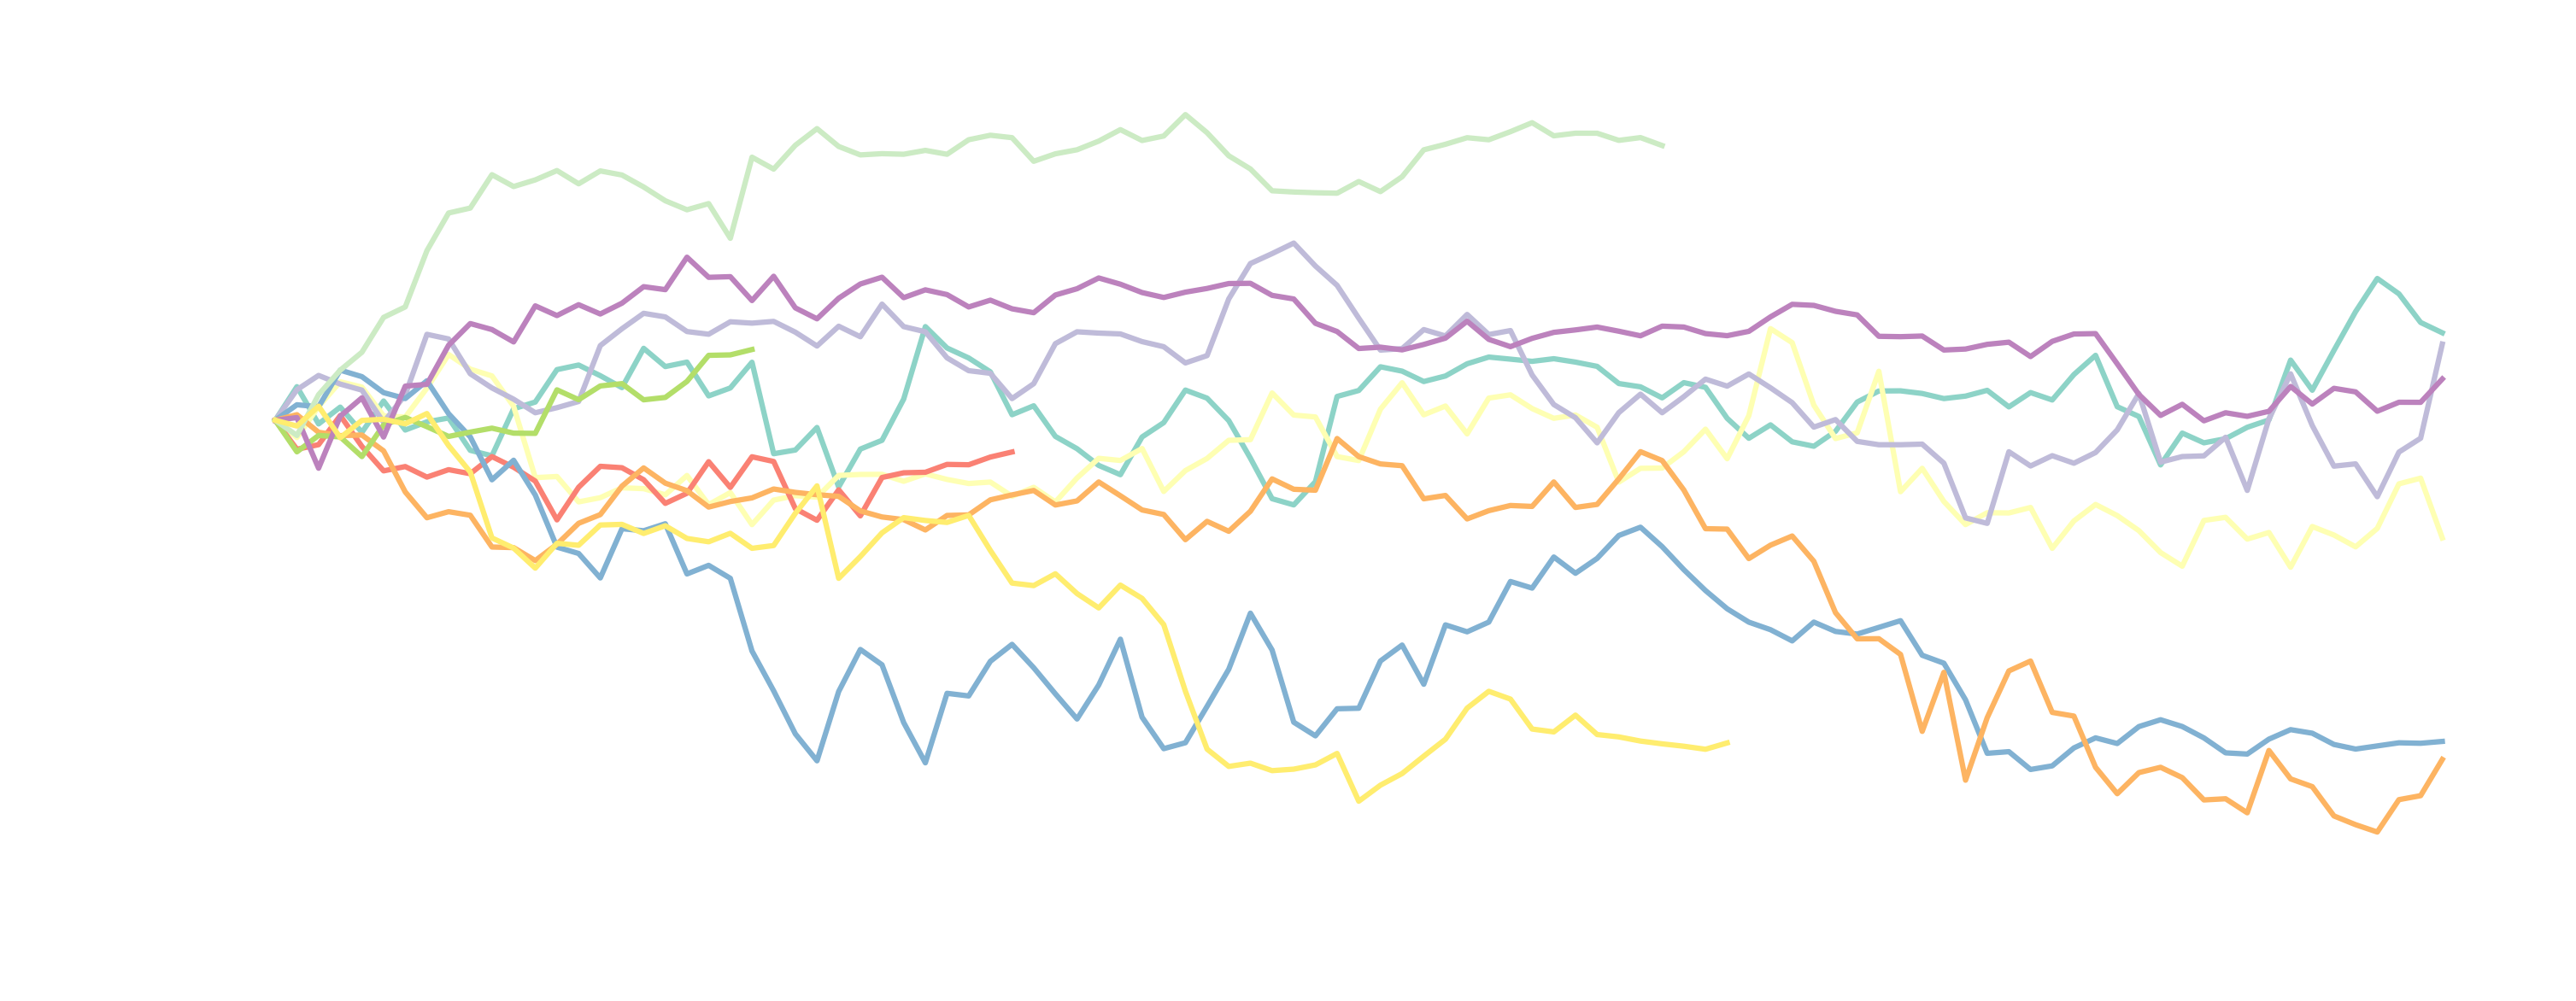

In [8]:
_, ax = plt.subplots(figsize=(12, 4), dpi=300)
ax.plot(np.linspace(ms.time, T, N_STEPS + 1), paths.T)
ax.set_title("Naive Euler")
ax.set_xlabel("Time")
ax.set_ylabel("Stock price")
plt.show()

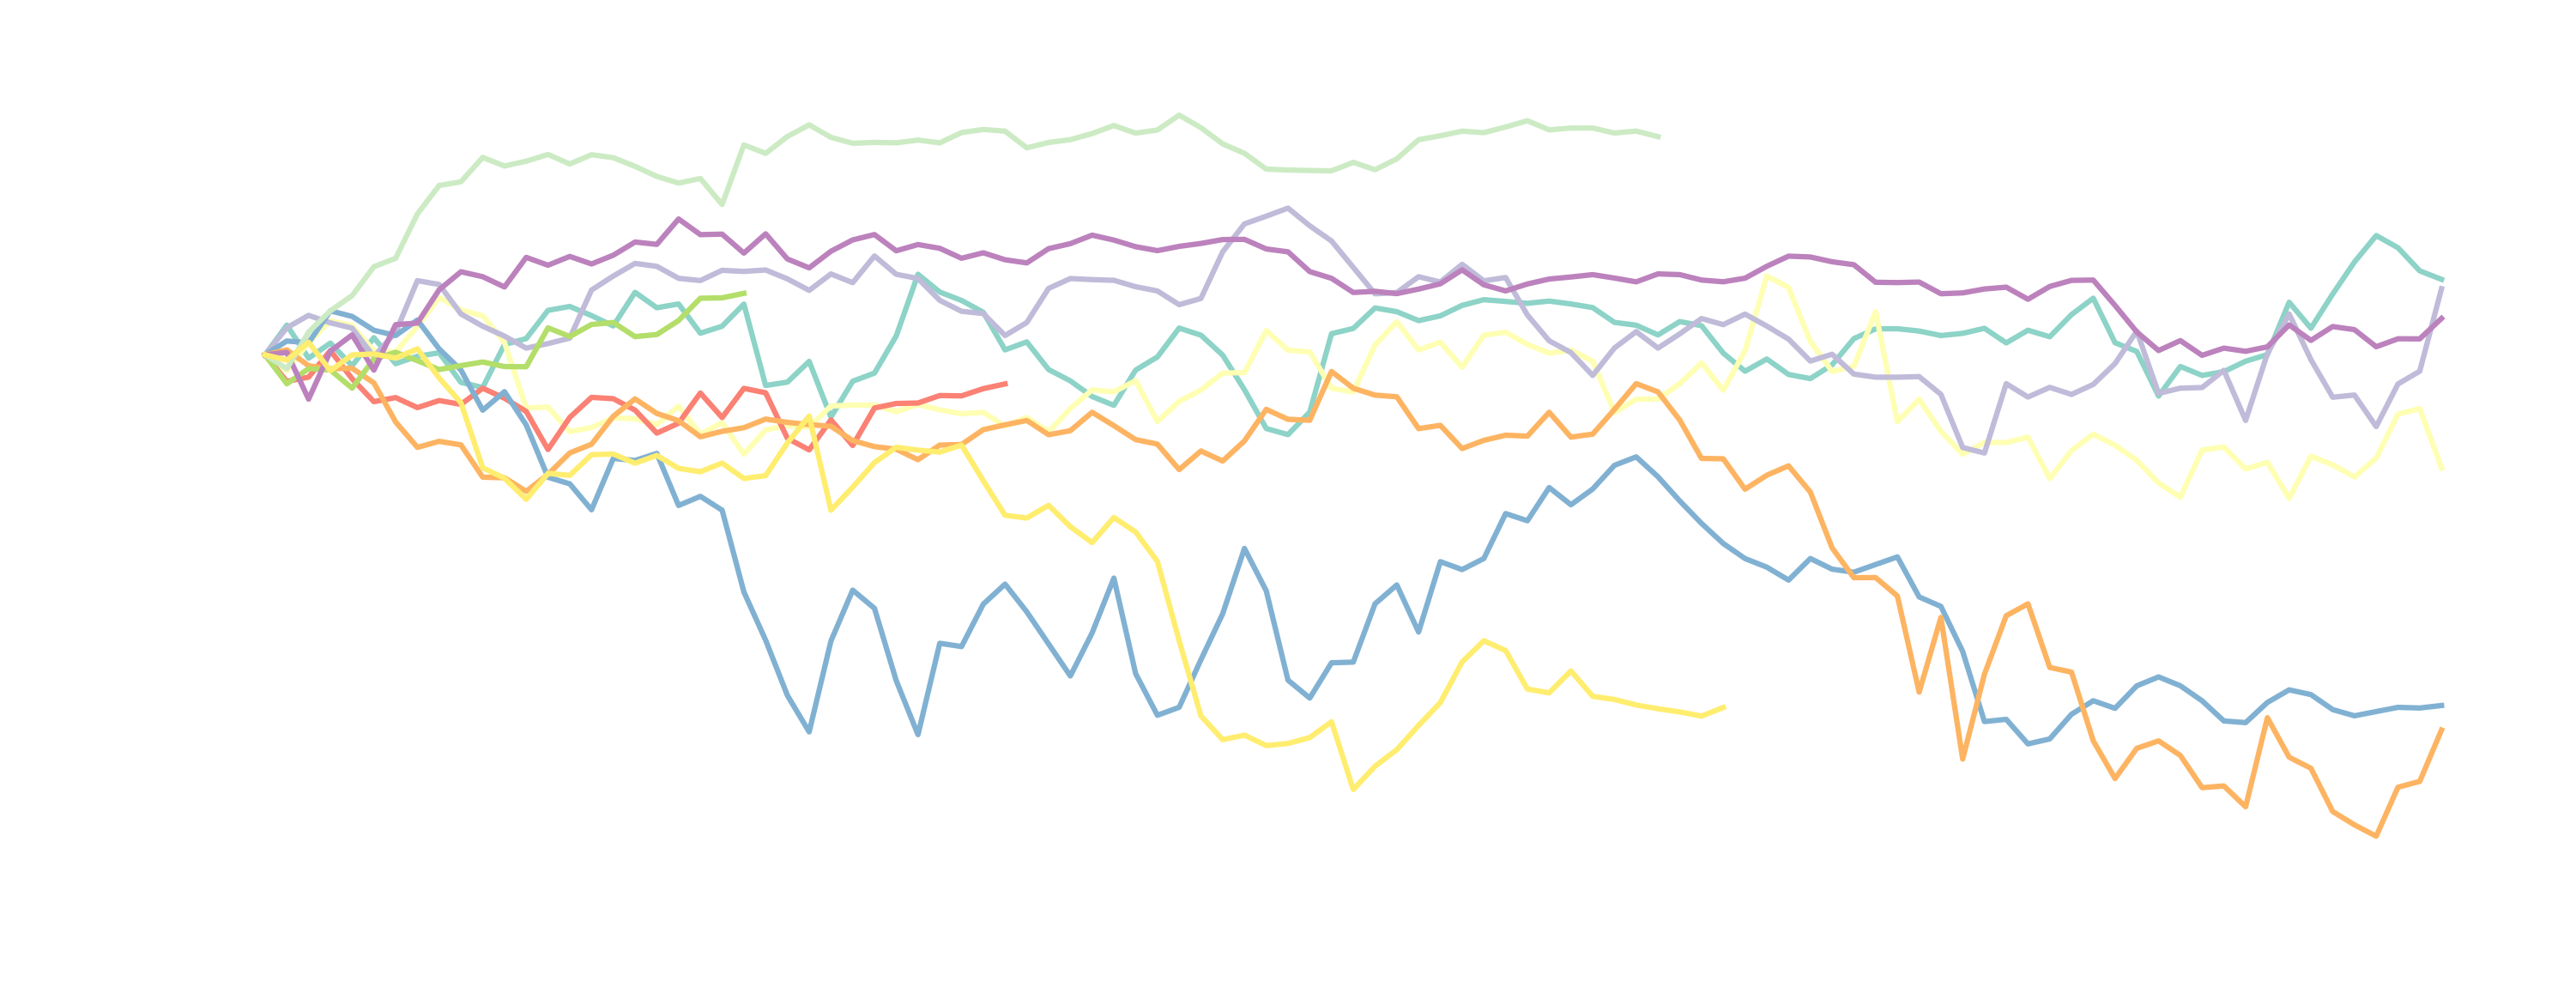

In [9]:
_, ax = plt.subplots(figsize=(12, 4), dpi=300)
ax.plot(np.linspace(ms.time, T, N_STEPS + 1), np.log(paths.T))
ax.set_title("Naive Euler")
ax.set_xlabel("Time")
ax.set_ylabel("Stock price")
plt.show()

In [10]:
np.isnan(paths).any()

True

In [11]:
paths.min()

nan

In [12]:
(paths < 0).mean()

0.0

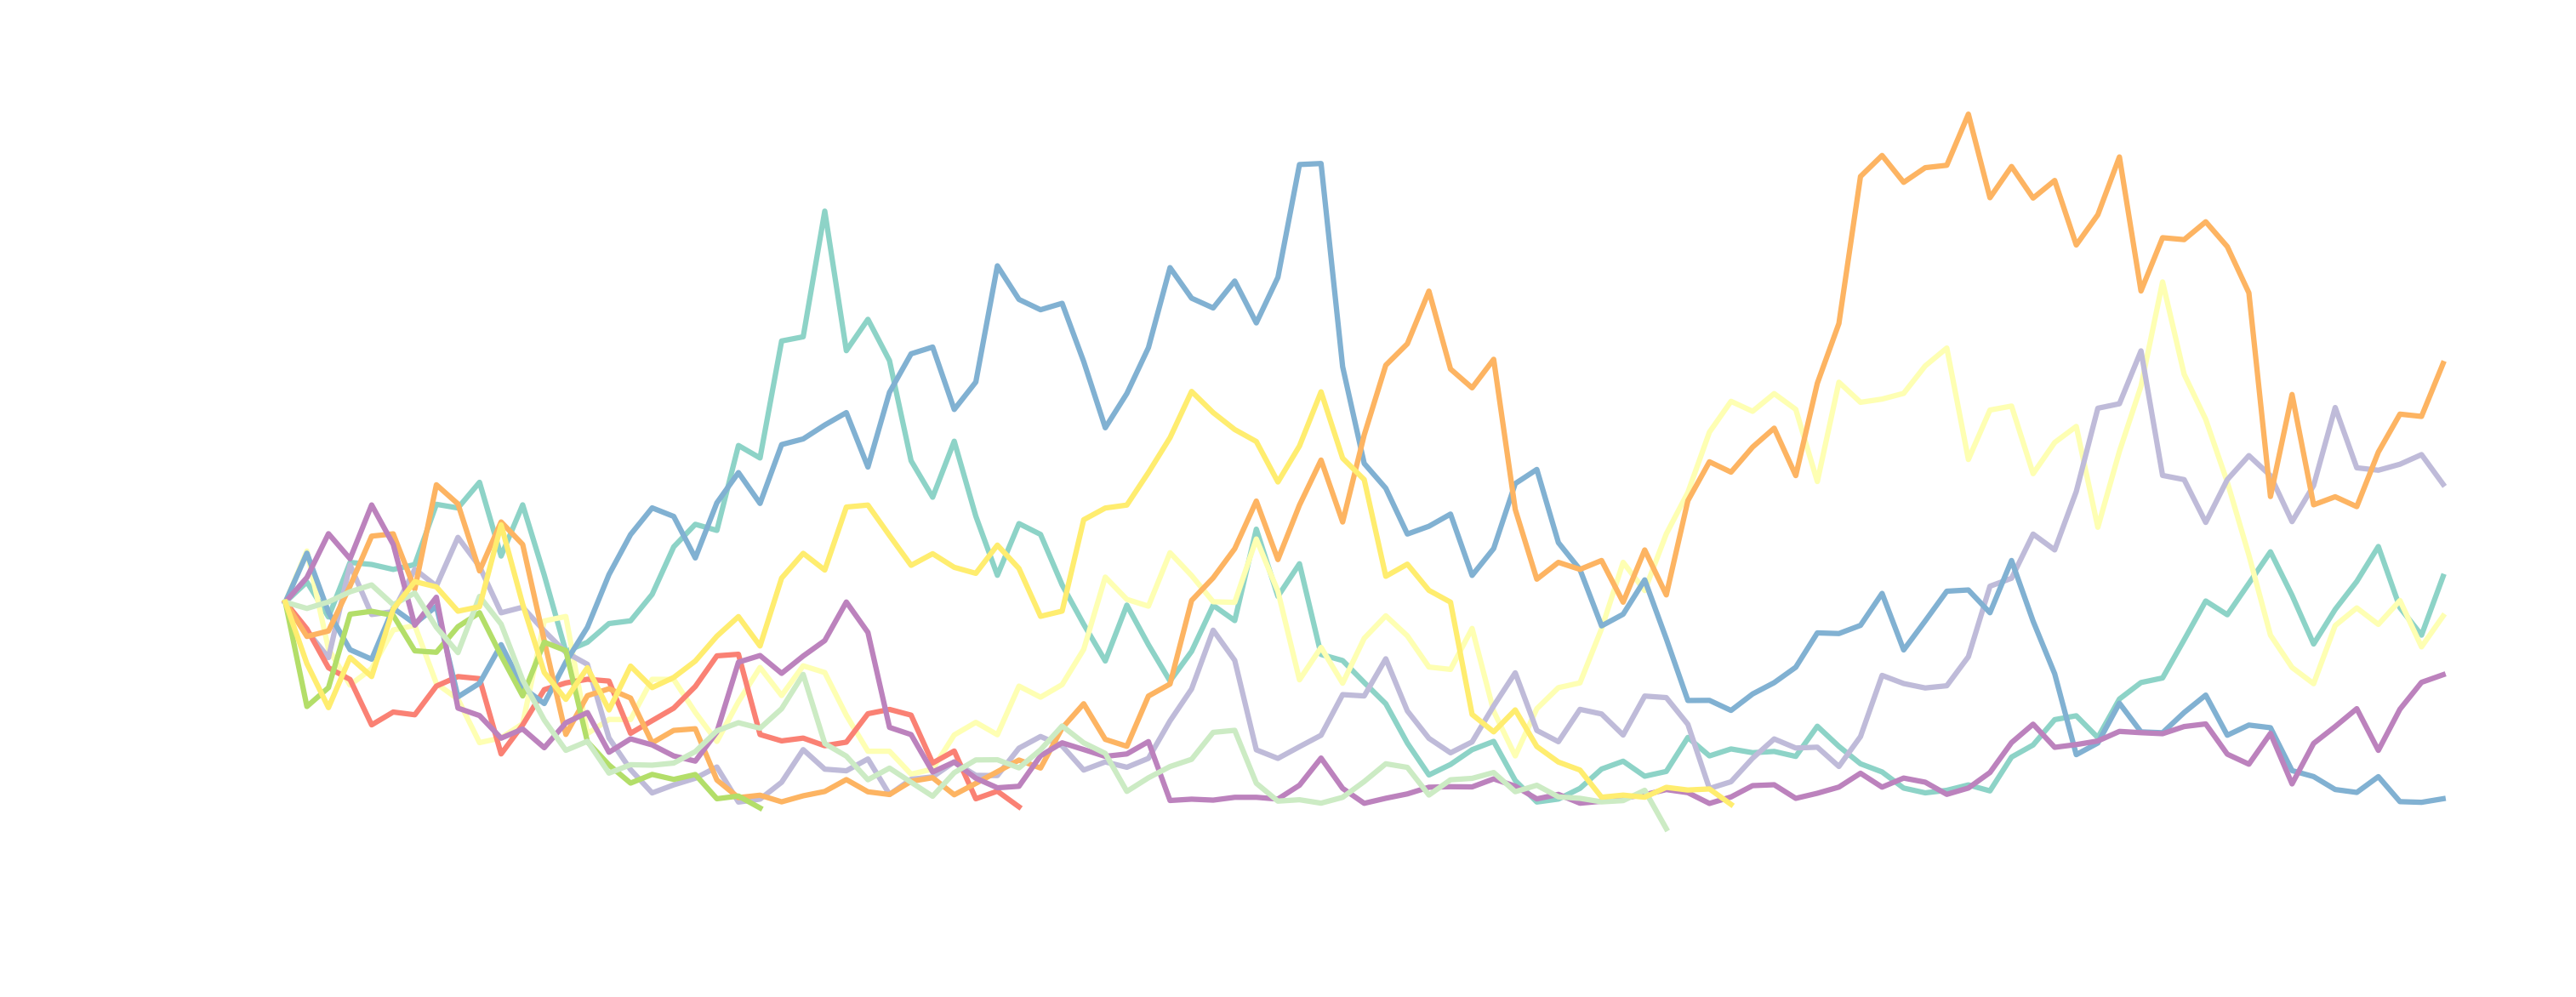

In [13]:
variance = np.stack([s.variance for s in states], axis=-1)

_, ax = plt.subplots(figsize=(12, 4), dpi=300)
ax.plot(np.linspace(ms.time, T, N_STEPS + 1), variance.T)
ax.set_title("Naive Euler")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
plt.show()

## 2. Log Euler

\begin{align*}
&\hat X_{t_{i+1}} = \hat X_{t_i} 
  + (r - \hat v_{t_i}^+/2)\Delta t 
  + \sqrt{\hat v_{t_i}^+} 
    (\rho \Delta W_{t_{i+1}}^1 + \sqrt{1-\rho^2} \Delta W_{t_{i+1}}^2), \\
&\hat v_{t_{t+i}} = \hat v_{t_i} + \kappa(\theta - \hat v_{t_i}^+) \Delta t 
  + \sigma \sqrt{\hat v_{t_i}^+} \Delta W_{t_{i+1}}^1,\\
&\hat S_{t_{i+1}} = \exp(\hat X_{t_{i+1}})
\end{align*}

In [1]:
@dataclass
class LogEulerSimulState(BaseHestonSimulState):
    def __init__(
        self,
        params: HestonParams,
        ms: MarketState,
        shape: Union[int, tuple[int]],
    ):
        self._log_stock_price = np.full(shape, np.log(ms.stock_price))
        self._variance = np.full(shape, params.v)
        self._interest_rate = ms.interest_rate
        self._p = params
    
    @property
    def log_stock_price(self):
        return self._log_stock_price
    
    @property
    def stock_price(self):
        return np.exp(self._log_stock_price)
    
    @property
    def variance(self):
        return self._variance

    def advance(
        self,
        dt: float,
        random: np.random.Generator,
    ):
        z1, z2 = random.normal(size=(2, *np.shape(self._log_stock_price)))
        dW_v = z1 * math.sqrt(dt)
        dW_s = math.sqrt(dt) * (self._p.rho * z1 + math.sqrt(1 - self._p.rho**2) * z2)
        new_v = (
            self._variance
            + self._p.kappa * (self._p.theta - self._variance) * dt
            + self._p.sigma * np.sqrt(self._variance) * dW_v
        )
        new_log_s = (
            self._log_stock_price
            + (self._interest_rate - self._variance / 2) * dt
            + np.sqrt(self._variance) * dW_s
        )
        self._log_stock_price = new_log_s
        # self.variance = np.maximum(new_v, 0)
        self._variance = np.where(
            new_v > 0,
            new_v,
            new_v - 2 * self._p.sigma * np.sqrt(self._variance) * dW_v
        )

NameError: name 'dataclass' is not defined

In [15]:
hs = LogEulerSimulState(params, ms, N_PATHS)
paths, states = simulate_heston(
    # params,
    replace(params, theta=20.0),
    hs,
    time_stop=T,
    n_time_steps=N_STEPS,
    ret_intermediate_states=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
np.isnan(paths).any()

False

In [17]:
(paths < 0).mean()

0.0

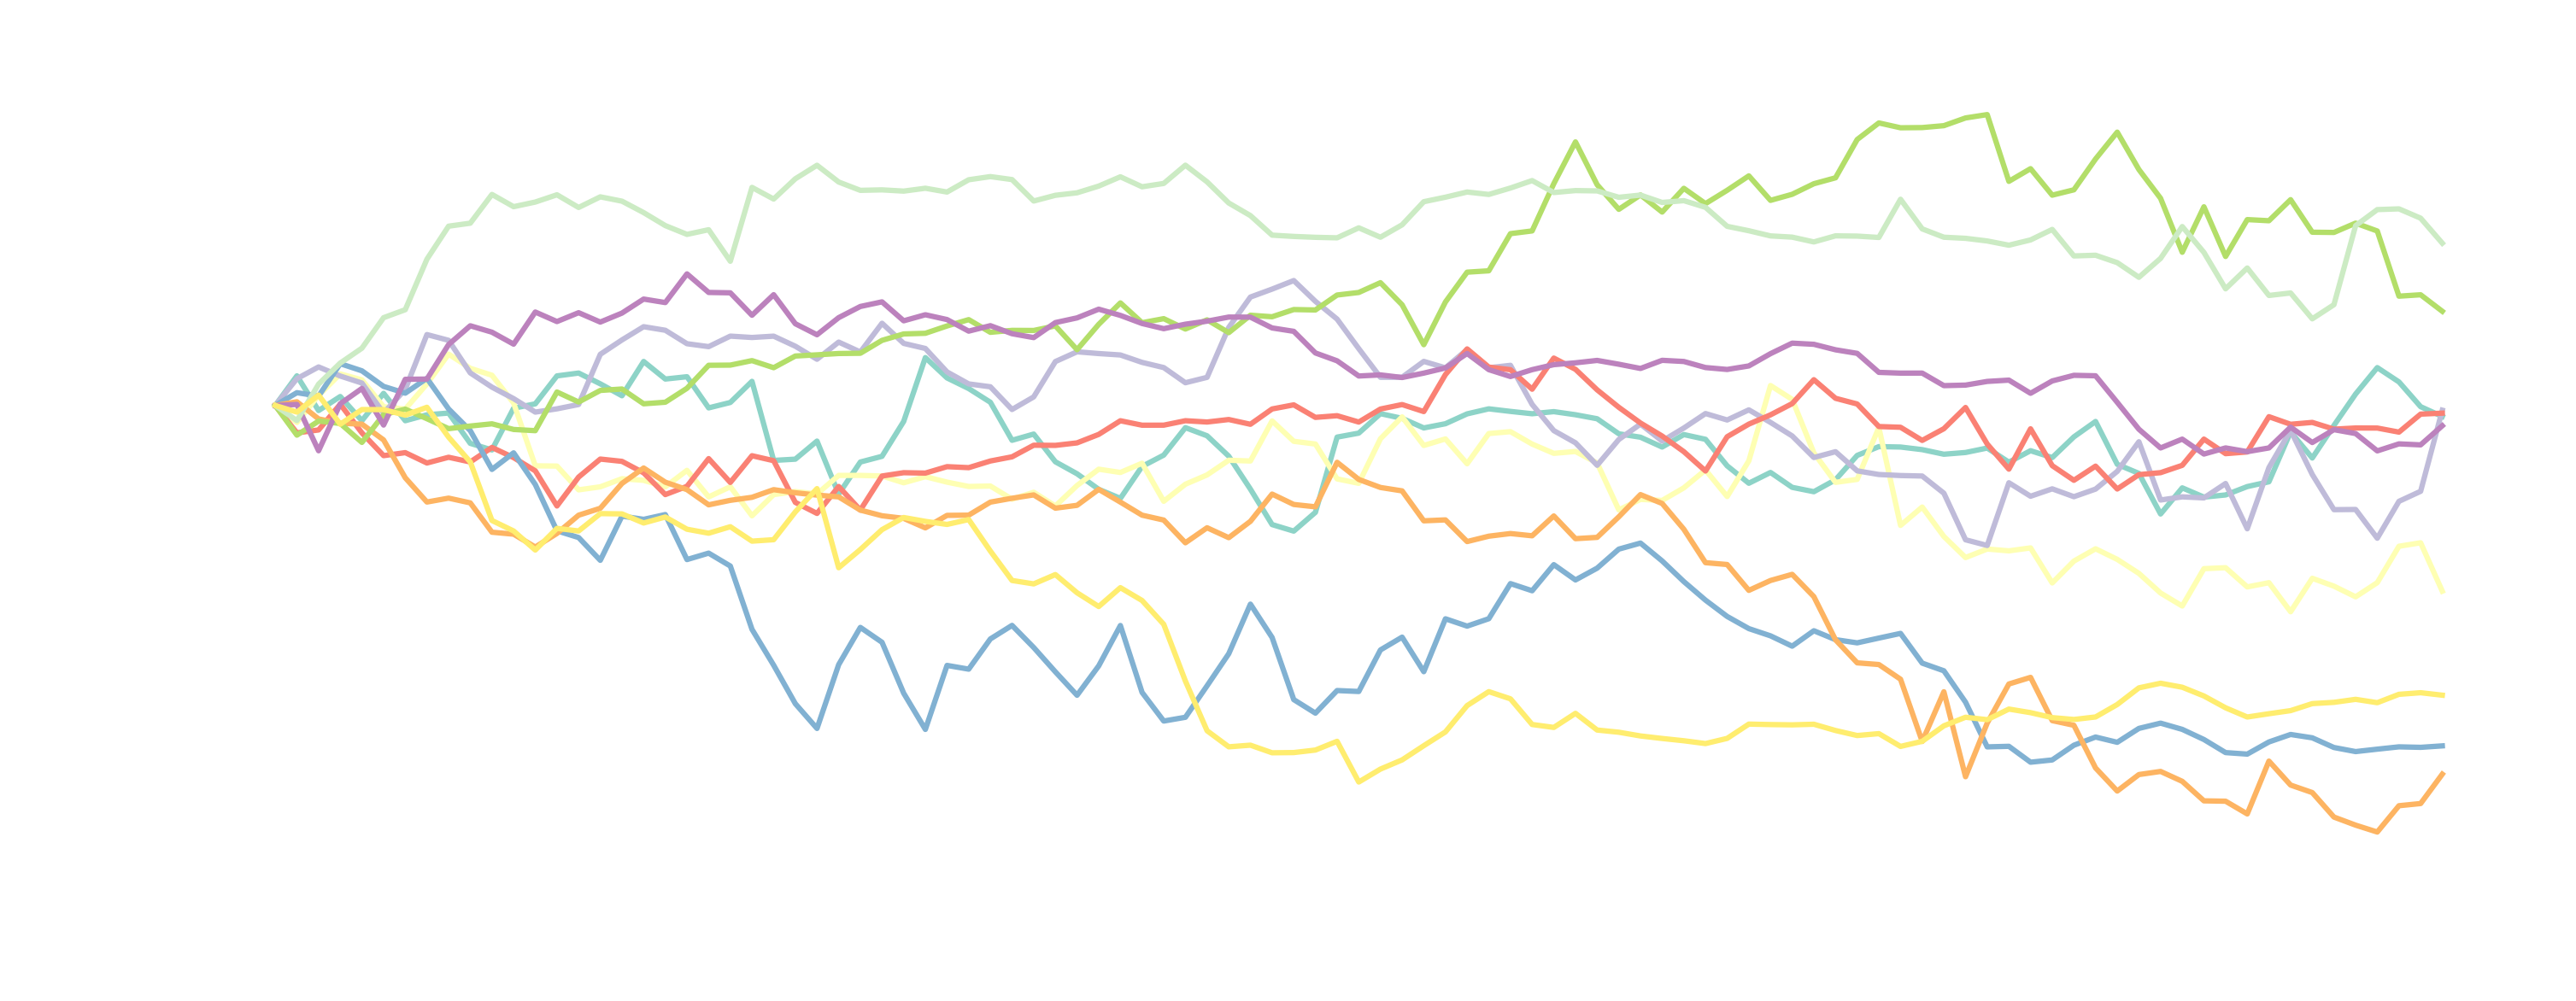

In [18]:
_, ax = plt.subplots(figsize=(12, 4), dpi=300)
ax.plot(np.linspace(ms.time, T, N_STEPS + 1), paths.T)
ax.set_title("Log Euler")
ax.set_xlabel("Time")
ax.set_ylabel("Stock price")
plt.show()

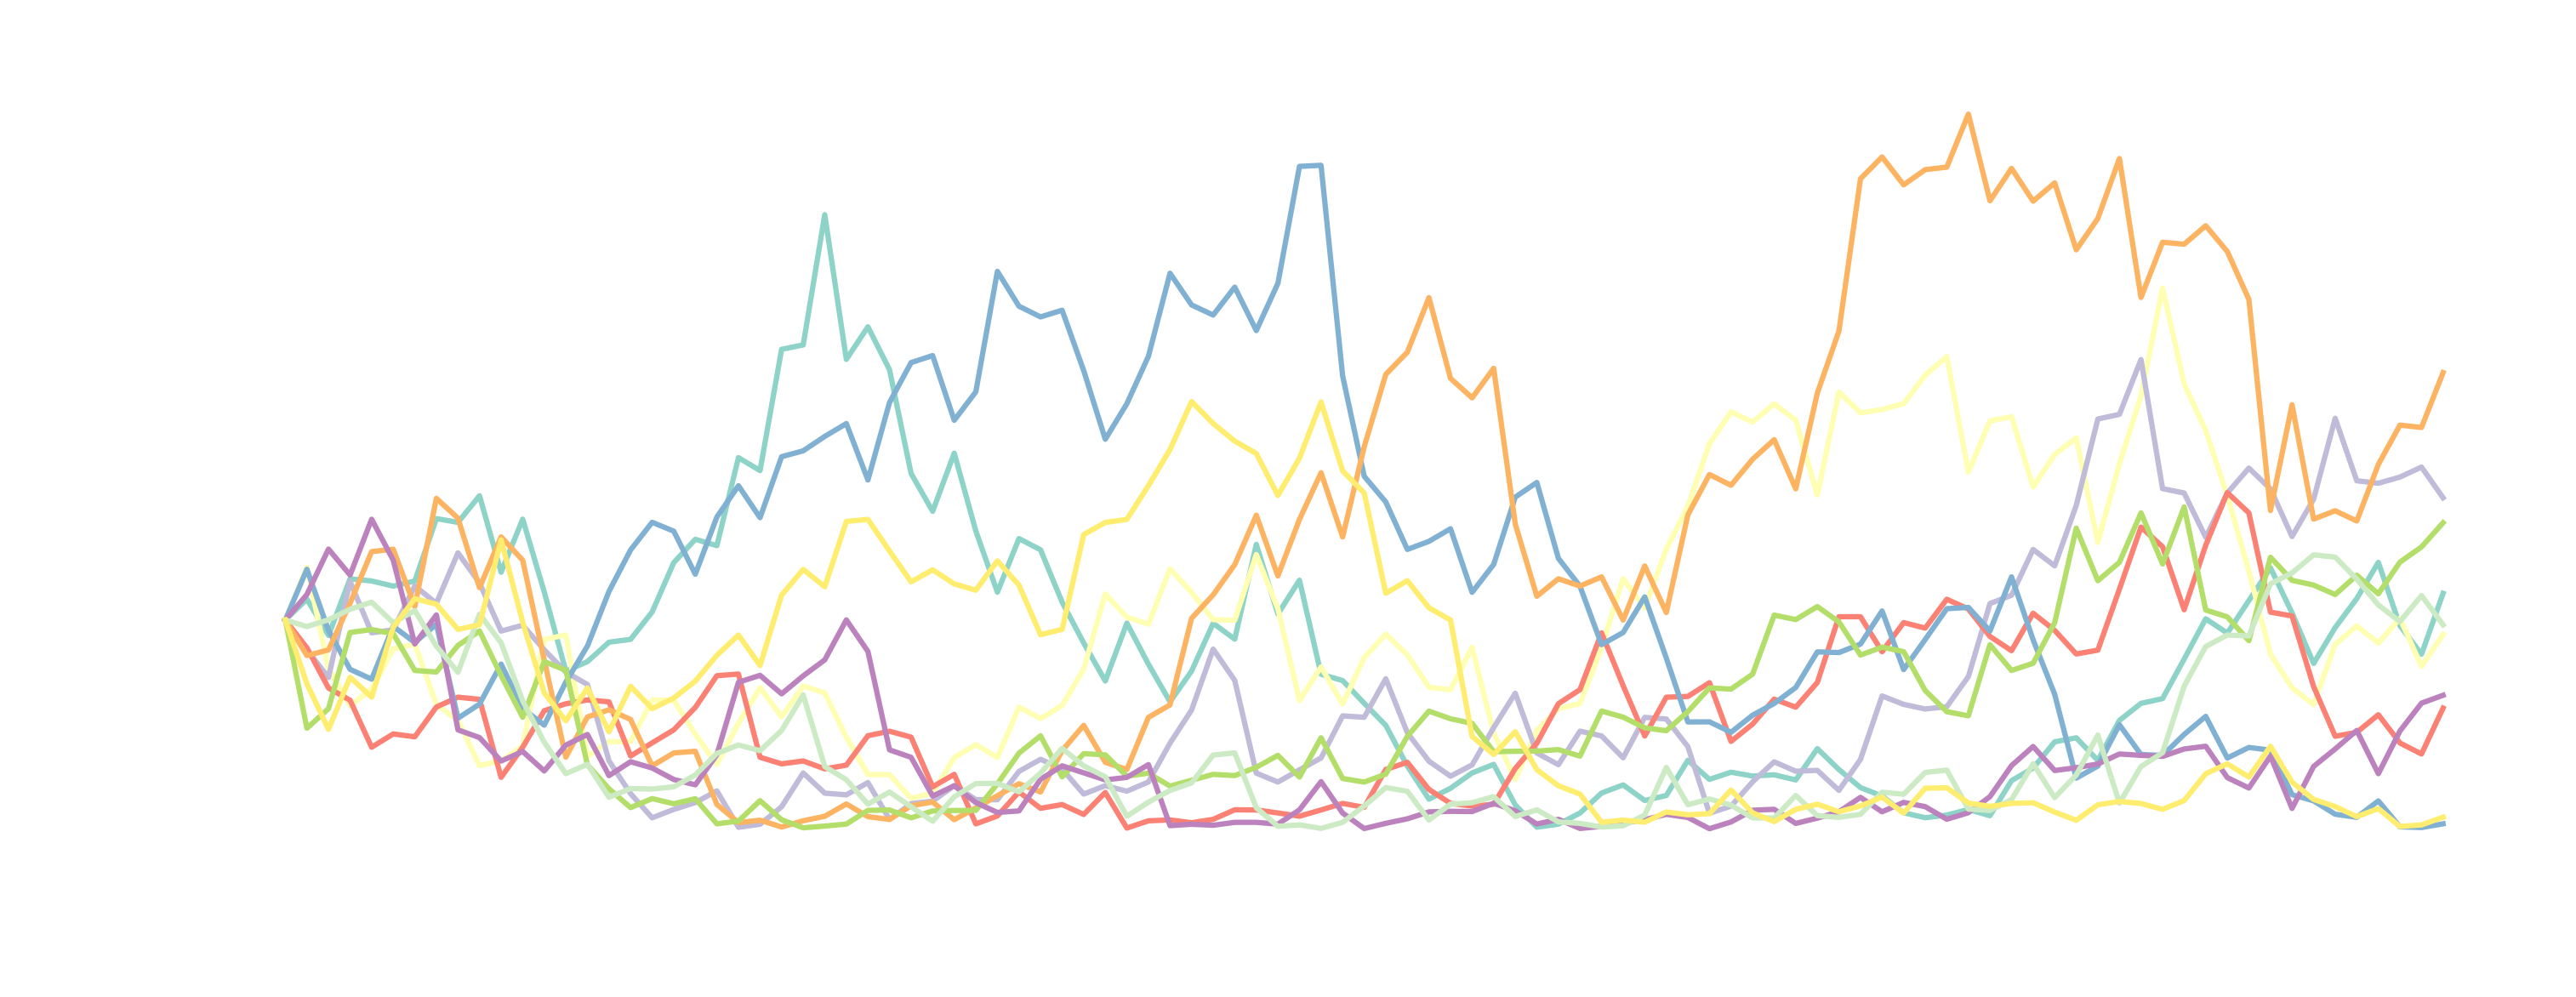

In [19]:
variance = np.stack([s.variance for s in states], axis=-1)

_, ax = plt.subplots(figsize=(12, 4), dpi=300)
ax.plot(np.linspace(ms.time, T, N_STEPS + 1), variance.T)
ax.set_title("Naive Euler")
ax.set_xlabel("Time")
ax.set_ylabel("Variance")
plt.show()

## 3. Exact Simulation (Broadie-Kaya)

\begin{align*}
&S_t = S_u\exp\biggl(
  r(t-u) - \frac12 \int_u^t v_s  ds 
  + \rho\int_u^t \sqrt{v_s} d W_s^1 
  + \sqrt{1-\rho^2} \int_u^t \sqrt{v_s} d W_s^2\biggr),\\
&v_t = v_u + \kappa\theta(t-u) - \kappa\int_u^t v_s ds 
  + \sigma \int_u^t \sqrt{v_s} d W_s^1.
\end{align*}

We cat just sample from the distributions of each of these terms:

1. Sample $v_t$ given $v_u$;
1. Sample $\int_u^t v_s ds$ given $v_t$ и $v_u$;
1. Express $\int_u^t \sqrt{v_s} d W_s^1$ from the equation for $v_t$;
1. Obtain $S_t$.

The conditional distribution of $v_t \mid v_u$ is known:
$$
\mathrm{Law}(v_t \mid v_u =v ) 
  = \frac{\sigma^2(1-e^{-\kappa(t-u)})}{4\kappa} 
  \tilde\chi_d^2\biggl(
    \frac{4\kappa e^{-\kappa(t-u)}}{\sigma^2(1-e^{-\kappa(t-u)})}v
  \biggr), \quad
d = \frac{4\theta\kappa}{\sigma^2},
$$
where $\tilde\chi_d^2$ is a non-central chi-squared distribution.

To sample from $\chi_d'^2(\lambda)$ we can use the following property:
$$
\chi_d'^2(\lambda) \sim \chi^2_{d + 2N},
$$
where $N \sim \mathrm{Pois}(\lambda\,/\,2)$.

But for step 2. we need to:
- obtain the characteristic function of the random variable (analitycally known),
- invert it to obtain the CDF, and
- sample using the Smirnov's transform.

Too complicated.

In [20]:
def sample_noncentral_chi2(
    random: np.random.Generator,
    df: Floats,
    lam: Floats,
):
    pois = random.poisson(lam / 2)
    return random.chisquare(df + 2 * pois)

## 4. Andersen

Two main ideas (comparing to the Broadie-Kaya scheme):
1. Use Euler approximation for sampling $\int_u^t v_s ds$.
1. Non-central chi-squared distribution can be aproximated as well.

**Only the 1-st idea is implemented**

In [21]:
@dataclass
class AndersenLikeSimulState(BaseHestonSimulState):
    def __init__(
        self,
        params: HestonParams,
        ms: MarketState,
        shape: Union[int, tuple[int]],
    ):
        self._log_stock_price = np.full(shape, np.log(ms.stock_price))
        self._variance = np.full(shape, params.v)
        self._interest_rate = ms.interest_rate
        self._p = params
    
    @property
    def log_stock_price(self):
        return self._log_stock_price
    
    @property
    def stock_price(self):
        return np.exp(self._log_stock_price)
    
    @property
    def variance(self):
        return self._variance
    
    @staticmethod
    def _sample_noncentral_chi2(
        random: np.random.Generator,
        df: Floats,
        lam: Floats,
    ):
        pois = random.poisson(lam / 2)
        return random.chisquare(df + 2 * pois)

    def advance(
        self,
        dt: float,
        random: np.random.Generator,
    ):
        k0 = (
            -self._p.rho * self._p.kappa * self._p.theta
            * dt / self._p.sigma
        )
        k2 = self._p.rho / self._p.sigma
        k1 = (self._p.kappa * k2 - 0.5) * dt - k2
        k3 = (1 - self._p.rho ** 2) * dt

        c = 4 * self._p.kappa / self._p.sigma ** 2
        decay = np.exp(-self._p.kappa * dt)

        new_v = (1 - decay) / c * self._sample_noncentral_chi2(
            random,
            df=c * self._p.theta,
            lam=self._variance * c * decay / (1 - decay),
        )
        new_log_s = (
            self._log_stock_price + k0 + k1 * self._variance + k2 * new_v
            + np.sqrt(k3 * self._variance) * random.normal(size=np.shape(self._log_stock_price))
        )
        
        self._log_stock_price = new_log_s
        self._variance = new_v

In [22]:
hs = AndersenLikeSimulState(params, ms, N_PATHS)
paths, states = simulate_heston(
    params,
    # replace(params, theta=20.0),
    hs,
    time_stop=T,
    n_time_steps=N_STEPS,
    ret_intermediate_states=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

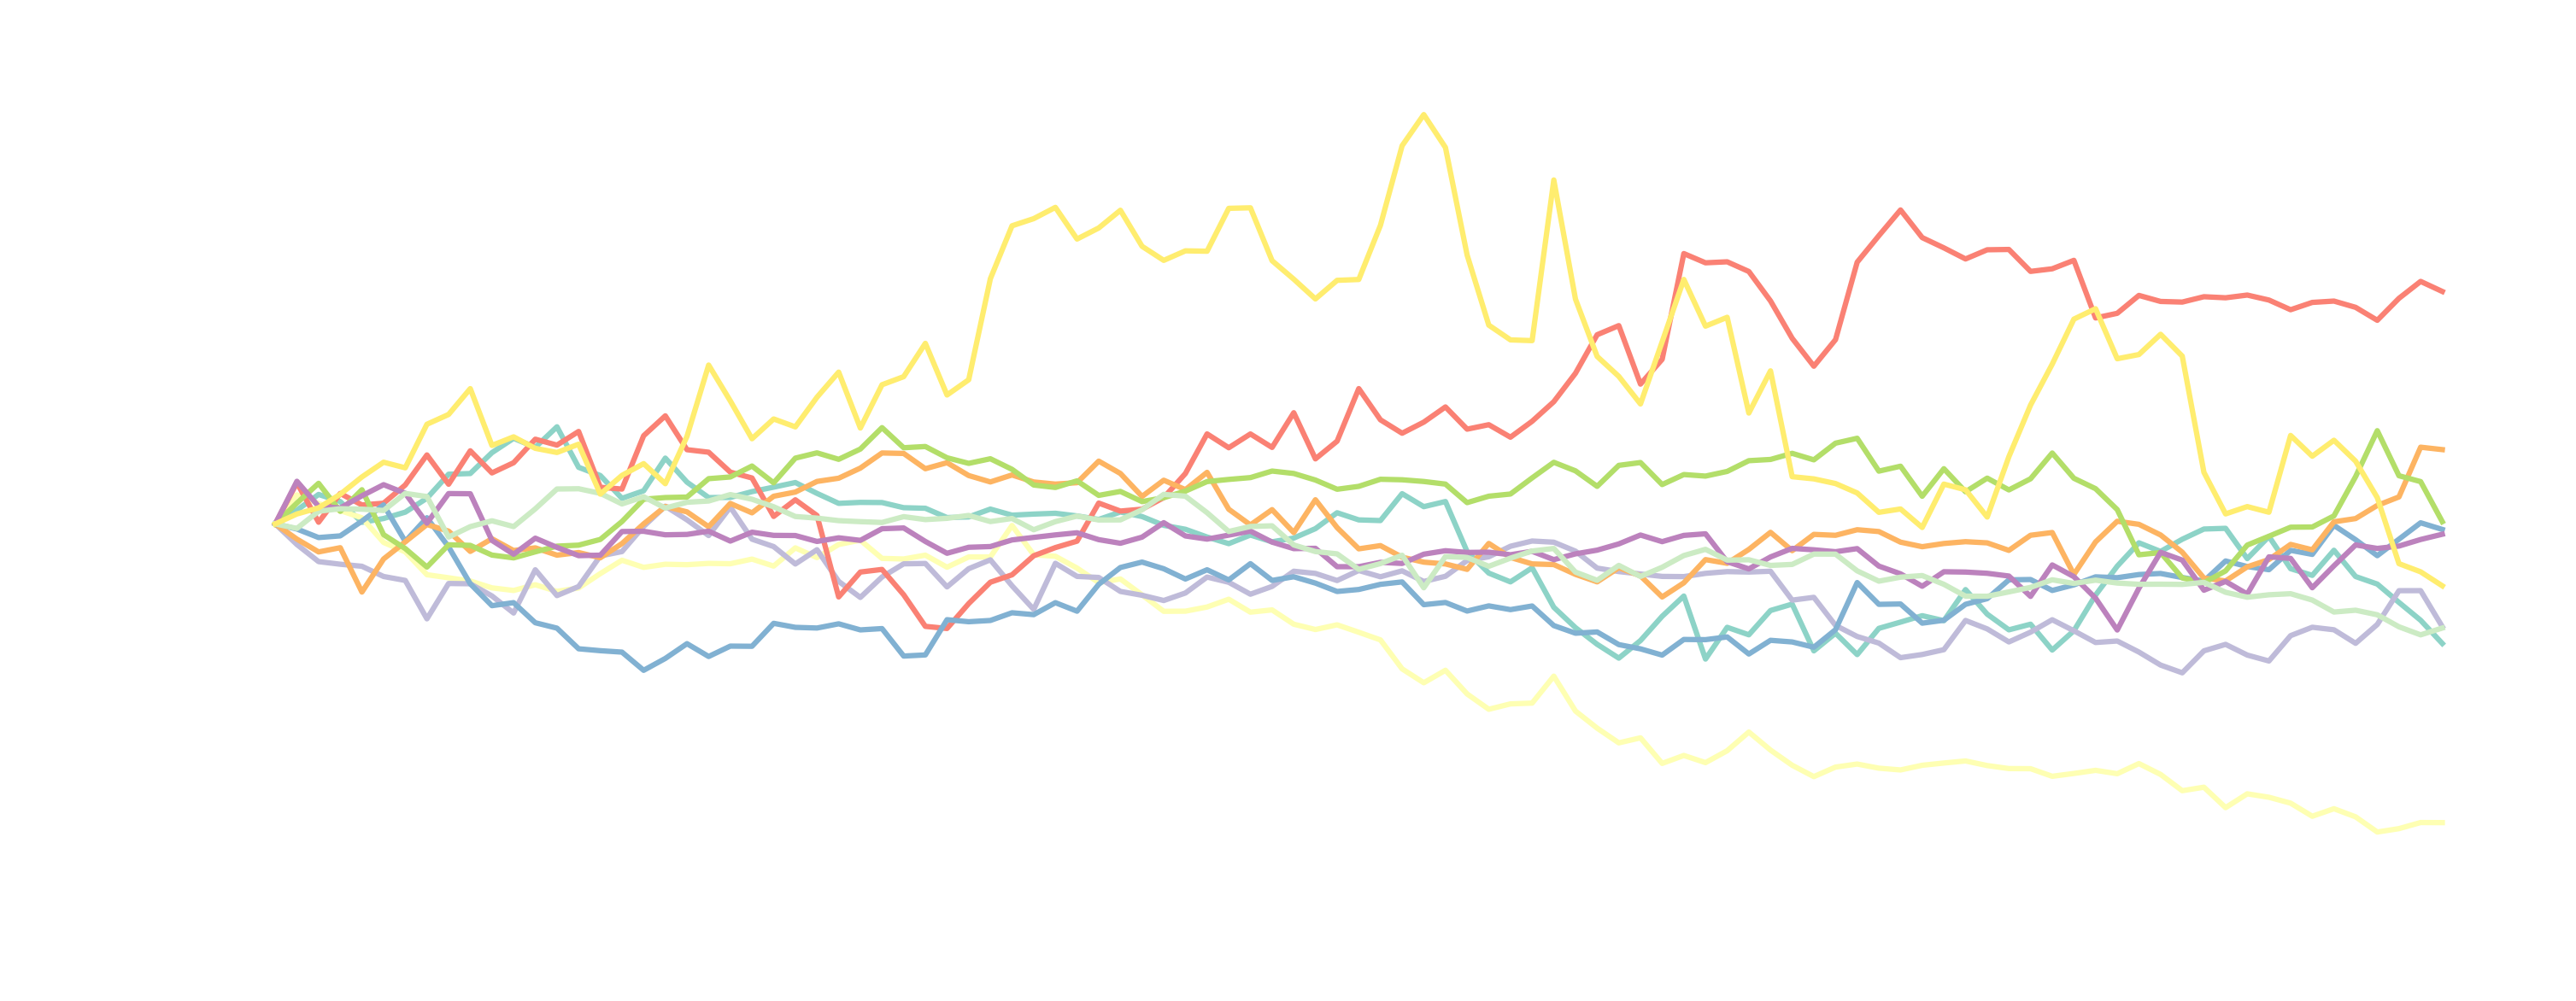

In [23]:
_, ax = plt.subplots(figsize=(12, 4), dpi=300)
ax.plot(np.linspace(ms.time, T, N_STEPS + 1), paths.T)
ax.set_title("Andersen-like")
ax.set_xlabel("Time")
ax.set_ylabel("Stock price")
plt.show()